# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import sagemaker
from sagemaker import get_execution_role
import subprocess



# magic word for producing visualizations in notebook
%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Matplotlib is building the font cache; this may take a moment.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `population_demo.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `customer_demo.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `train.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `test.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Setup Sagemaker Session
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
execution_role = sagemaker.session.get_execution_role()
region = sagemaker_session.boto_region_name

print(f'bucket: {bucket}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
bucket: sagemaker-us-east-1-709677954768


In [3]:
#download data to notebook
#define data location constants
local_data_dir = 'data'
s3_data_path = f's3://{bucket}/data' 
s3_model_path = f's3://{bucket}/model'

In [4]:
# subprocess.run(f"aws s3 sync  {s3_data_path} ./{local_data_dir}", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [5]:
chunk_size = 100000
gen_pop_demo = pd.read_csv(f'{s3_data_path}/population_demo.csv', chunksize=chunk_size)
customer_demo = pd.read_csv(f'{s3_data_path}/customers_demo.csv', chunksize=chunk_size)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [6]:
gen_pop_sample = next(gen_pop_demo)
customer_sample = next(customer_demo)

/tmp/ipykernel_6449/3644439205.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  gen_pop_sample = next(gen_pop_demo)
/tmp/ipykernel_6449/3644439205.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customer_sample = next(customer_demo)


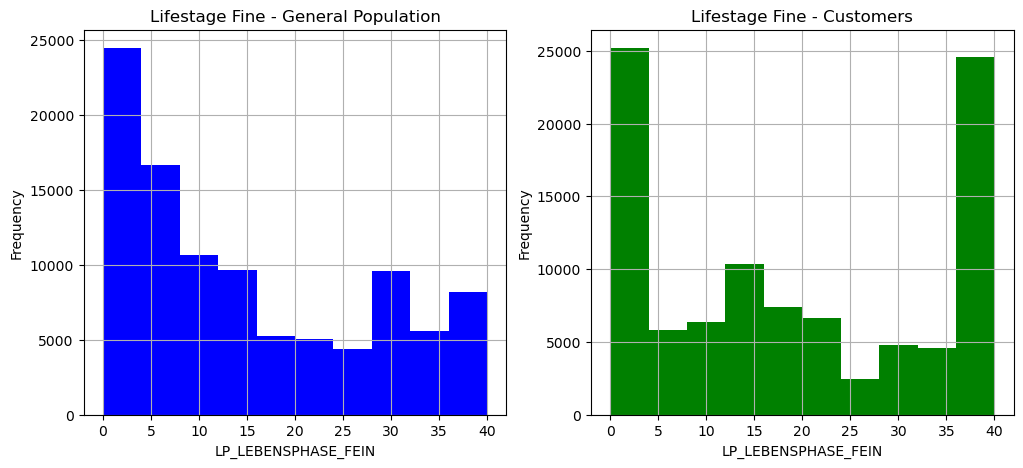

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

gen_pop_sample['LP_LEBENSPHASE_FEIN'].hist(ax=ax1, color='blue')
ax1.set_title('Lifestage Fine - General Population')
ax1.set_xlabel('LP_LEBENSPHASE_FEIN')
ax1.set_ylabel('Frequency')


customer_sample['LP_LEBENSPHASE_FEIN'].hist(ax=ax2, color='green')
ax2.set_title('Lifestage Fine - Customers')
ax2.set_xlabel('LP_LEBENSPHASE_FEIN')
ax2.set_ylabel('Frequency')
plt.savefig('visualizations/lifestyle-fine.png')

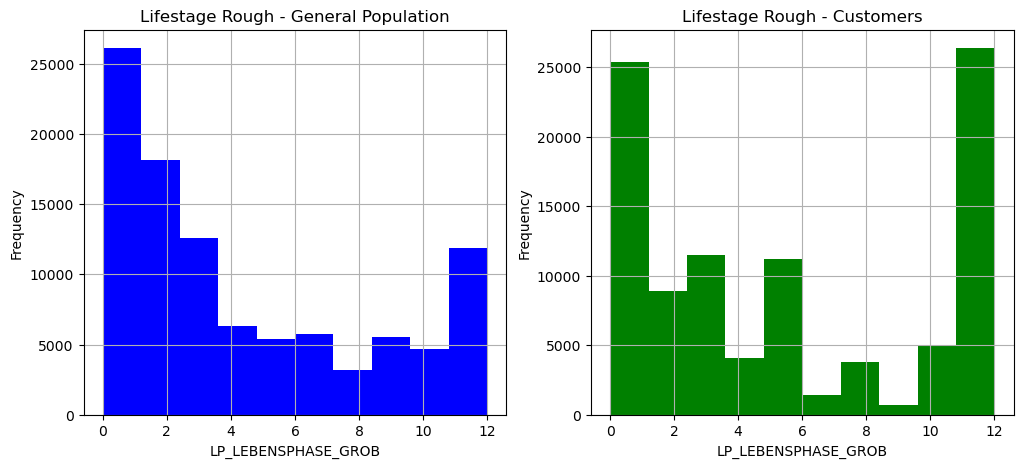

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

gen_pop_sample['LP_LEBENSPHASE_GROB'].hist(ax=ax1, color='blue')
ax1.set_title('Lifestage Rough - General Population')
ax1.set_xlabel('LP_LEBENSPHASE_GROB')
ax1.set_ylabel('Frequency')


customer_sample['LP_LEBENSPHASE_GROB'].hist(ax=ax2, color='green')
ax2.set_title('Lifestage Rough - Customers')
ax2.set_xlabel('LP_LEBENSPHASE_GROB')
ax2.set_ylabel('Frequency')
plt.savefig('visualizations/lifestyle-rough.png')

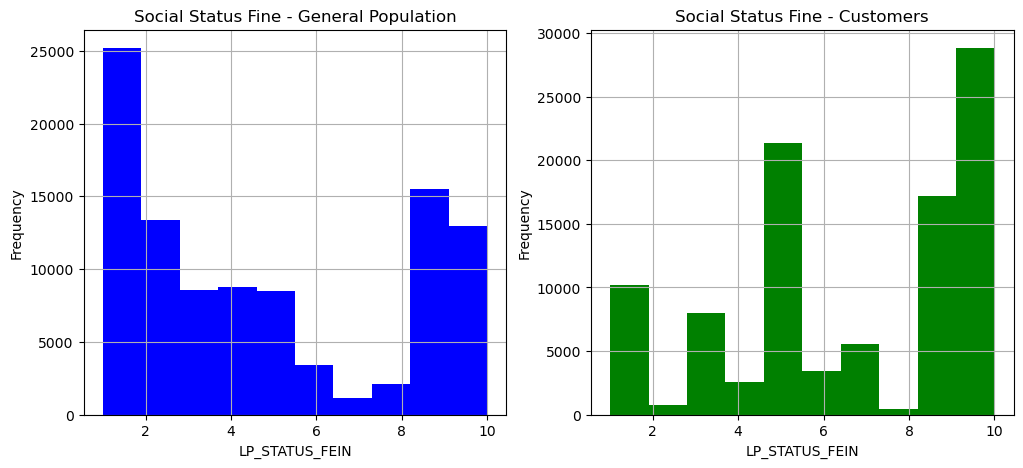

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

gen_pop_sample['LP_STATUS_FEIN'].hist(ax=ax1, color='blue')
ax1.set_title('Social Status Fine - General Population')
ax1.set_xlabel('LP_STATUS_FEIN')
ax1.set_ylabel('Frequency')


customer_sample['LP_STATUS_FEIN'].hist(ax=ax2, color='green')
ax2.set_title('Social Status Fine - Customers')
ax2.set_xlabel('LP_STATUS_FEIN')
ax2.set_ylabel('Frequency')
plt.savefig('visualizations/social-status-fine.png')

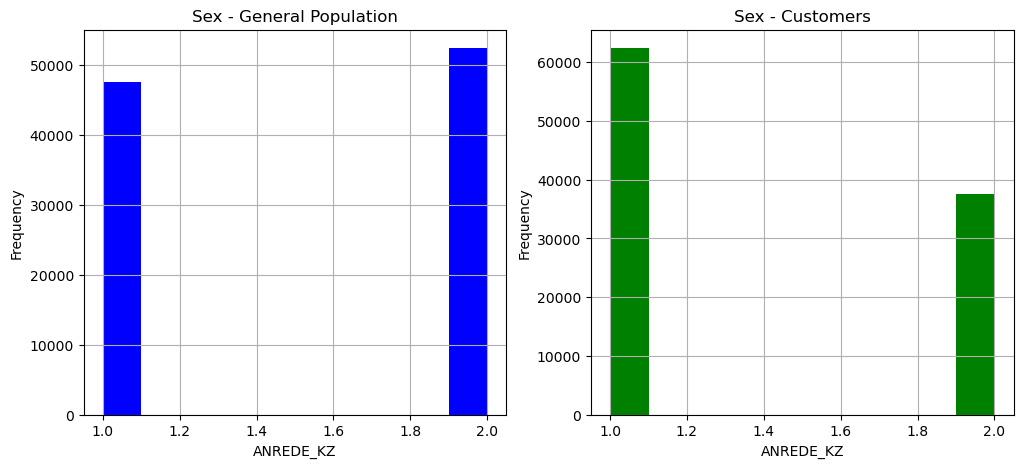

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

gen_pop_sample['ANREDE_KZ'].hist(ax=ax1, color='blue')
ax1.set_title('Sex - General Population')
ax1.set_xlabel('ANREDE_KZ')
ax1.set_ylabel('Frequency')


customer_sample['ANREDE_KZ'].hist(ax=ax2, color='green')
ax2.set_title('Sex - Customers')
ax2.set_xlabel('ANREDE_KZ')
ax2.set_ylabel('Frequency')
plt.savefig('visualizations/sex.png')

In [3]:
# # Get the directory of the current script or notebook
# current_directory = os.getcwd()

# # Specify the original paths
# original_azdias_path = os.path.join(current_directory, 'data', 'Term2', 'capstone', 'arvato_data', 'Udacity_AZDIAS_052018.csv')
# original_customers_path = os.path.join(current_directory, 'data', 'Term2', 'capstone', 'arvato_data', 'Udacity_CUSTOMERS_052018.csv')

# # Specify the new paths in the same directory
# azdias_path = os.path.join(current_directory, 'Udacity_AZDIAS_052018.csv')
# customers_path = os.path.join(current_directory, 'Udacity_CUSTOMERS_052018.csv')

# # Move the files to the current directory
# shutil.copy(original_azdias_path, azdias_path)
# shutil.copy(original_customers_path, customers_path)

# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias.to_csv('azdias_new.csv', index=False)
customers.to_csv('customers_new.csv', index=False)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_train.to_csv('train.csv', index=False)
mailout_test.to_csv('test.csv', index=False)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
